In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [11]:
def quantize_mxfp8(x, tile_size=32, man_bits=3, exp_bits=4):
    """
    模拟 MXFP8 块级量化: 每 tile 内共享 exponent，mantissa 截断到 man_bits。
    自动适配小 tensor（如 bias）。
    """
    x = x.clone().detach()
    shape = x.shape
    numel = x.numel()

    # 如果 tensor 太小，tile_size 改成 numel
    tile = min(tile_size, numel)
    x = x.view(-1, tile)
    out = torch.zeros_like(x)

    for i, block in enumerate(x):
        if torch.all(block == 0):
            continue
        emax = torch.log2(torch.max(torch.abs(block)) + 1e-30)
        scale = 2 ** (torch.floor(emax) - (2 ** (exp_bits - 1) - 1))
        norm = block / scale
        mant = torch.round(norm * (2 ** man_bits))
        mant = torch.clamp(mant, -(2 ** man_bits), (2 ** man_bits) - 1)
        out[i] = mant / (2 ** man_bits) * scale

    return out.view(shape)



# =========================================================
# 2️⃣ 定义一个“模型量化”函数
# =========================================================
def quantize_model_weights(model, tile_size=64):
    """
    对模型参数做 MXFP8 模拟量化。
    """
    q_model = type(model)()  # 复制同类模型
    q_model.load_state_dict(model.state_dict())

    with torch.no_grad():
        for name, param in q_model.named_parameters():
            param.copy_(quantize_mxfp8(param, tile_size=tile_size))
    return q_model


# =========================================================
# 3️⃣ 示例模型（你可以替换成自己的）
# =========================================================
class SmallNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)


# =========================================================
# 4️⃣ 精度对比实验
# =========================================================
def evaluate_model_precision_loss(model, x_input, tile_size=64):
    # 量化模型
    model_fp32 = model.eval()
    model_mxfp8 = quantize_model_weights(model_fp32, tile_size=tile_size).eval()

    # 前向传播
    with torch.no_grad():
        y_fp32 = model_fp32(x_input)
        y_mxfp8 = model_mxfp8(x_input)

    # 误差度量
    abs_err = torch.abs(y_fp32 - y_mxfp8)
    rel_err = abs_err / (torch.abs(y_fp32) + 1e-30)
    mse = torch.mean((y_fp32 - y_mxfp8) ** 2).item()
    mae = torch.mean(abs_err).item()
    snr = 10 * torch.log10(torch.sum(y_fp32 ** 2) / torch.sum((y_fp32 - y_mxfp8) ** 2)).item()
    cosine = F.cosine_similarity(y_fp32.flatten(), y_mxfp8.flatten(), dim=0).item()

    print(f"\n--- MXFP8 Precision Evaluation ---")
    print(f"Mean Absolute Error (MAE): {mae:.6e}")
    print(f"Mean Square Error (MSE):   {mse:.6e}")
    print(f"Signal-to-Noise Ratio:     {snr:.2f} dB")
    print(f"Cosine Similarity:         {cosine:.6f}")

    # 误差分布可视化
    plt.figure(figsize=(6,4))
    plt.hist((y_fp32 - y_mxfp8).cpu().numpy().flatten(), bins=100, color='steelblue', alpha=0.8)
    plt.title("Output Error Distribution (FP32 - MXFP8)")
    plt.xlabel("Error Value")
    plt.ylabel("Count")
    plt.show()

    return {
        "mae": mae,
        "mse": mse,
        "snr": snr,
        "cosine": cosine,
        "abs_err": abs_err,
        "rel_err": rel_err
    }






--- MXFP8 Precision Evaluation ---
Mean Absolute Error (MAE): 2.162176e-01
Mean Square Error (MSE):   7.315880e-02
Signal-to-Noise Ratio:     0.00 dB
Cosine Similarity:         0.108110


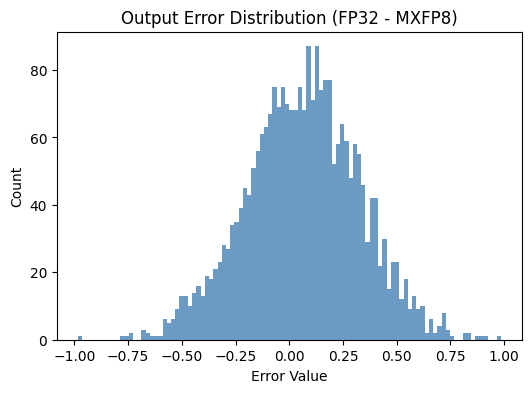

In [12]:
# =========================================================
# 5️⃣ 运行示例
# =========================================================
if __name__ == "__main__":
    torch.manual_seed(0)
    model = SmallNet()
    x = torch.randn(256, 128)

    metrics = evaluate_model_precision_loss(model, x, tile_size=64)